# Generate Training Space

For now, we will take the $R$-matrix parameter posteriors from a previous run to define training distributions. In the future, we would like to use AZURE2's bset fit and error estimates. Unfortunately, we want to sample ANCs. The best fit when ANCs are varied is pretty bad.

In [1]:
import os
import sys
import pickle
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import model

sys.path.append('/home/odell/7Be')
import run


os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
with open('/spare/odell/7Be/CP/samples/model_1_2021-08-06-02-55-37.pkl', 'rb') as f:
    run = pickle.load(f)

In [3]:
flat_chain = run.get_flat_chain()[:, :-1]
theta_star = run.get_theta_star(max_likelihood=False)

In [4]:
ns, nd = flat_chain.shape

In [5]:
nd

32

In [6]:
# fig, ax = plt.subplots(nd, figsize=(3, nd*3))
# fig.patch.set_facecolor('white')

# for i in range(flat_chain.shape[1]):
#     ax[i].plot(flat_chain[:, i], alpha=0.5)
#     ax[i].axhline(theta_star[i], color='r')

In [7]:
def characterize_dist(d):
    low, med, high = np.quantile(d, [0.16, 0.5, 0.84])
    upper = high - med
    lower = med - low
    sigma = np.max([upper, lower])
    return med, sigma


def construct_dist(d):
    med, sigma = characterize_dist(d)
    return stats.norm(med, sigma)

In [8]:
distributions = [construct_dist(d) for d in flat_chain.T]

In [9]:
rand_points = np.array([d.rvs(1000) for d in distributions]).T

In [10]:
with Pool(processes=16) as pool:
    samples = pool.map(model.calculate, rand_points)

In [11]:
with Pool(processes=16) as pool:
    posterior_samples = pool.map(model.calculate, flat_chain[-1000:, :])

In [12]:
with Pool(processes=16) as pool:
    posterior_samples = pool.map(model.calculate, flat_chain[-1000:, :])

In [13]:
width = 0.5
fat_flat_chain = stats.norm(1, width).rvs(1000)[:, np.newaxis]*flat_chain[-1000:, :]

In [14]:
with Pool(processes=16) as pool:
    fat_posterior_samples = pool.map(model.calculate, fat_flat_chain)

In [15]:
np.save('datfiles/rand_points.npy', rand_points)
np.save('datfiles/rand_samples.npy', samples)

np.save('datfiles/posterior_chain.npy', flat_chain[-1000:, :])
np.save('datfiles/posterior_samples.npy', posterior_samples)

np.save(f'datfiles/fat_{width:.1f}_posterior_chain.npy', fat_flat_chain)
np.save(f'datfiles/fat_{width:.1f}_posterior_samples.npy', fat_posterior_samples)

np.save('datfiles/theta_star.npy', theta_star)

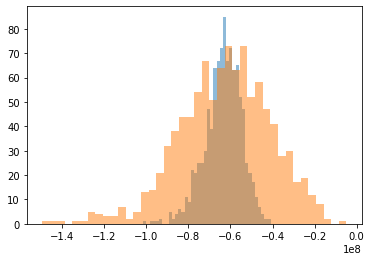

In [24]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

i = 1

ax.hist(flat_chain[-1000:, i], bins=40, alpha=0.5)
ax.hist(fat_flat_chain[:, i], bins=40, alpha=0.5);